<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Tokenization
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Tokenizer fitting (clinical-trials)
  </div> 


  <div style="
      font-size: 15px; 
      line-height: 12px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Jean-baptiste AUJOGUE - Hybrid Intelligence
  </div> 

  
  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [ALBERT finetuning](#albert) <br>
3. [Inference](#inference) <br>



#### Reference

- Hugginface full list of [tutorial notebooks](https://github.com/huggingface/transformers/tree/main/notebooks) (see also [here](https://huggingface.co/docs/transformers/main/notebooks#pytorch-examples))
- Huggingface full list of [training scripts](https://github.com/huggingface/transformers/tree/main/examples/pytorch)
- Huggingface [tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/language_modeling_from_scratch.ipynb) on language models
- Huggingface [course](https://huggingface.co/course/chapter7/3?fw=tf) on language models
- Huggingface [training script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py) on language models
- SentencePiece Unigram logic described in [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (2018)](https://arxiv.org/pdf/1804.10959.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import random
import copy
import string
import json
from itertools import chain

# data
import pandas as pd
import numpy as np
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
    load_from_disk,
)
import transformers
from transformers import AlbertConfig, AutoConfig, AutoTokenizer, AlbertTokenizerFast

# tokenize
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Transformers settings

In [3]:
transformers.__version__

'4.22.2'

#### Custom paths & imports

In [4]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'clinical trials CTTI')
path_to_save = os.path.join(path_to_repo, 'saves', 'MLM')
path_to_src  = os.path.join(path_to_repo, 'src')

In [5]:
sys.path.insert(0, path_to_src)

#### Constants

In [6]:
dataset_name = 'clinical-trials-ctti'
base_model_name = "albert-base-v2"
final_model_name = "albert-small-clinical-trials"

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

We generate a collection of instances of the `datasets.Dataset` class. 

Note that these are different from the fairly generic `torch.utils.data.Dataset` class. 

## 1.1 Load Clinical Trials corpus

[Table of content](#TOC)

In [7]:
with open(os.path.join(path_to_data, '{}.txt'.format(dataset_name)), 'r', encoding = 'utf-8') as f:
    texts = [t.strip() for t in f.readlines()]

In [8]:
dataset = Dataset.from_dict({'text': texts}, features = Features({'text': Value(dtype = 'string')}))

In [9]:
dataset[:3]

{'text': ['This study will test the ability of extended release nifedipine (Procardia XL), a blood pressure medication, to permit a decrease in the dose of glucocorticoid medication children take to treat congenital adrenal hyperplasia (CAH). This protocol is designed to assess both acute and chronic effects of the calcium channel antagonist, nifedipine, on the hypothalamic-pituitary-adrenal axis in patients with congenital adrenal hyperplasia. The multicenter trial is composed of two phases and will involve a double-blind, placebo-controlled parallel design. The goal of Phase I is to examine the ability of nifedipine vs. placebo to decrease adrenocorticotropic hormone (ACTH) levels, as well as to begin to assess the dose-dependency of nifedipine effects. The goal of Phase II is to evaluate the long-term effects of nifedipine; that is, can attenuation of ACTH release by nifedipine permit a decrease in the dosage of glucocorticoid needed to suppress the HPA axis? Such a decrease would, 

## 1.2 Build tokenizer

[Table of content](#TOC)


In [10]:
def batch_iterator(dataset, batch_size = 512):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i: i + batch_size]['text']

In [11]:
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [12]:
v2i = base_tokenizer.get_vocab()
i2v = {i: v for v, i in v2i.items()}
[i2v[i] for i in range(5)]

['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]']

In [13]:
# issue with this ! yields badly formed vocabulary, with punctuations at middle of tokens
# tokenizer = base_tokenizer.train_new_from_iterator(batch_iterator(dataset, batch_size = 512), vocab_size = 5000)

In [14]:
# see the different pre-tokenizers at https://huggingface.co/docs/tokenizers/components#pretokenizers
# see also https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb#scrollTo=RZvnUm2PZV0H

custom_pre_tokenizer = pre_tokenizers.Sequence([
    # base albert pre-tokenizer
    pre_tokenizers.WhitespaceSplit(),
    pre_tokenizers.Metaspace(replacement = "▁", add_prefix_space = True),
    
    # isolate special characters in order not to have them at the middle of a word
    # this is put after Metaspace in order not to include extra spaces
    pre_tokenizers.Digits(),
    pre_tokenizers.Punctuation(behavior = "isolated"),
])

In [15]:
tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer     = base_tokenizer.backend_tokenizer.normalizer
tokenizer.pre_tokenizer  =  custom_pre_tokenizer #base_tokenizer.backend_tokenizer.pre_tokenizer 
tokenizer.post_processor = base_tokenizer.backend_tokenizer.post_processor
tokenizer.decoder        = base_tokenizer.backend_tokenizer.decoder

In [16]:
# vocab_size has realy unexpected behavior,
# see https://github.com/huggingface/tokenizers/issues/903
trainer = trainers.UnigramTrainer(
    vocab_size = 10000, 
    special_tokens = ['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]'], # order should be the same as base_tokenizer !
    unk_token = "<unk>",
)
tokenizer.train_from_iterator(batch_iterator(dataset, batch_size = 512), trainer = trainer)

In [17]:
tokenizer = AlbertTokenizerFast(tokenizer_object = tokenizer)

In [18]:
tokenizer.save_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))

('C:\\Users\\jb\\Desktop\\NLP\\Internal - Transformers for NLP\\saves\\MLM\\albert-small-clinical-trials\\tokenizer\\tokenizer_config.json',
 'C:\\Users\\jb\\Desktop\\NLP\\Internal - Transformers for NLP\\saves\\MLM\\albert-small-clinical-trials\\tokenizer\\special_tokens_map.json',
 'C:\\Users\\jb\\Desktop\\NLP\\Internal - Transformers for NLP\\saves\\MLM\\albert-small-clinical-trials\\tokenizer\\tokenizer.json')

In [19]:
v2i = tokenizer.get_vocab()
i2v = {i: v for v, i in v2i.items()}
[i2v[i] for i in range(5)]

['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]']

## 1.3 Inspect tokenizer

[Table of content](#TOC)


In [20]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save, final_model_name, 'tokenizer'))

In [21]:
len(tokenizer.get_vocab())

10000

<AxesSubplot: ylabel='Frequency'>

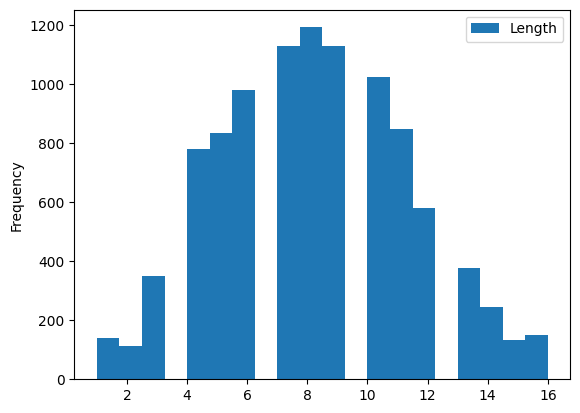

In [22]:
pd.DataFrame([len(t) for t in tokenizer.get_vocab()], columns = ['Length']).plot.hist(bins = 20)

In [23]:
[t for t in tokenizer.get_vocab() if len(t) <= 1]

['q',
 '•',
 '¬',
 '3',
 'i',
 'ø',
 's',
 '±',
 'x',
 '1',
 '"',
 'r',
 '^',
 '、',
 '÷',
 '*',
 '▁',
 'h',
 'μ',
 '9',
 '&',
 '=',
 'o',
 '¿',
 'g',
 '/',
 'α',
 'ζ',
 'χ',
 'w',
 '8',
 '+',
 '$',
 'n',
 't',
 '∞',
 '7',
 '□',
 '√',
 'æ',
 '.',
 '〖',
 '×',
 'і',
 '≦',
 'π',
 'η',
 'λ',
 '€',
 '▪',
 'т',
 'p',
 'a',
 '↑',
 '\uf061',
 'd',
 'b',
 '°',
 '˂',
 '●',
 '∼',
 '◦',
 ',',
 '∆',
 '{',
 'c',
 'ρ',
 '5',
 '→',
 'œ',
 '˃',
 '<',
 '#',
 ';',
 '。',
 'k',
 'ε',
 '|',
 'j',
 '≧',
 '\u202c',
 '4',
 '!',
 ']',
 '£',
 '↓',
 '⩾',
 '_',
 ':',
 '}',
 '≤',
 'τ',
 '△',
 '〗',
 'f',
 '⁄',
 'β',
 'ـ',
 'l',
 '§',
 'κ',
 'х',
 'ß',
 "'",
 'ι',
 '0',
 'γ',
 '®',
 'δ',
 'z',
 'u',
 ')',
 'v',
 '%',
 '>',
 '?',
 '☐',
 '@',
 '-',
 '[',
 '(',
 '†',
 'y',
 'm',
 'e',
 '‰',
 '≈',
 'σ',
 '2',
 '\\',
 '~',
 'θ',
 'ω',
 '≥',
 '·',
 '6',
 '©',
 'с',
 '∙',
 'ı']

In [24]:
tokenizer.get_vocab()

{'▁csf': 3919,
 'lingual': 5997,
 'boost': 7366,
 '▁oxygenation': 3001,
 '▁classified': 2841,
 '▁preservation': 4667,
 '▁teach': 5770,
 '▁effusion': 3863,
 '▁substitution': 6951,
 'ter': 906,
 '▁undertaken': 4095,
 '▁seldom': 9628,
 '▁objectives': 412,
 '▁attribute': 3808,
 '▁draw': 2677,
 '▁comorbidity': 3789,
 '▁extracellular': 5426,
 '▁gastriti': 8452,
 '▁mechanism': 1410,
 '▁staging': 3396,
 '▁predispos': 7872,
 '▁implant': 1169,
 '▁topiram': 6949,
 '▁similar': 730,
 'q': 379,
 '▁dehydration': 6656,
 '▁pathology': 1429,
 'healing': 5738,
 '▁sheet': 3261,
 'log': 3898,
 '▁gabapentin': 5602,
 '▁spectroscop': 3883,
 '▁cancers': 2338,
 '▁means': 1280,
 '▁donate': 4996,
 '▁from': 58,
 'thylprednisolone': 6708,
 '▁dexterit': 8937,
 '▁hydroxy': 3411,
 'agonist': 6637,
 '▁progenitor': 5994,
 '▁enzalut': 7180,
 'seronegative': 8466,
 '▁cataract': 2581,
 '▁implemente': 2154,
 '▁restoration': 2948,
 '▁intact': 4227,
 '▁thromboembolic': 4945,
 'european': 8966,
 '▁mortality': 507,
 'ischemic':

In [25]:
texts[0], tokenizer.decode(tokenizer(texts[0])['input_ids'])

('This study will test the ability of extended release nifedipine (Procardia XL), a blood pressure medication, to permit a decrease in the dose of glucocorticoid medication children take to treat congenital adrenal hyperplasia (CAH). This protocol is designed to assess both acute and chronic effects of the calcium channel antagonist, nifedipine, on the hypothalamic-pituitary-adrenal axis in patients with congenital adrenal hyperplasia. The multicenter trial is composed of two phases and will involve a double-blind, placebo-controlled parallel design. The goal of Phase I is to examine the ability of nifedipine vs. placebo to decrease adrenocorticotropic hormone (ACTH) levels, as well as to begin to assess the dose-dependency of nifedipine effects. The goal of Phase II is to evaluate the long-term effects of nifedipine; that is, can attenuation of ACTH release by nifedipine permit a decrease in the dosage of glucocorticoid needed to suppress the HPA axis? Such a decrease would, in turn, 

In [26]:
tokens = tokenizer.tokenize(texts[0])
ids = tokenizer(texts[0])['input_ids'][1:-1]
list(zip(tokens, ids))

[('▁this', 38),
 ('▁study', 28),
 ('▁will', 22),
 ('▁test', 122),
 ('▁the', 7),
 ('▁', 5),
 ('ability', 233),
 ('▁of', 9),
 ('▁extended', 2023),
 ('▁release', 1289),
 ('▁nifedip', 9167),
 ('in', 92),
 ('e', 20),
 ('▁', 5),
 ('(', 19),
 ('pro', 922),
 ('cardia', 7723),
 ('▁', 5),
 ('x', 125),
 ('l', 35),
 (')', 18),
 (',', 6),
 ('▁', 5),
 ('a', 11),
 ('▁blood', 80),
 ('▁pressure', 245),
 ('▁medication', 318),
 (',', 6),
 ('▁to', 13),
 ('▁permit', 4364),
 ('▁', 5),
 ('a', 11),
 ('▁decrease', 580),
 ('▁in', 15),
 ('▁the', 7),
 ('▁dose', 106),
 ('▁of', 9),
 ('▁glucocorticoid', 6067),
 ('▁medication', 318),
 ('▁children', 172),
 ('▁take', 479),
 ('▁to', 13),
 ('▁treat', 844),
 ('▁congenital', 1636),
 ('▁adrenal', 4276),
 ('▁hyperplasia', 5496),
 ('▁', 5),
 ('(', 19),
 ('c', 31),
 ('a', 11),
 ('h', 57),
 (')', 18),
 ('.', 8),
 ('▁this', 38),
 ('▁protocol', 285),
 ('▁is', 25),
 ('▁', 5),
 ('designed', 470),
 ('▁to', 13),
 ('▁assess', 161),
 ('▁both', 182),
 ('▁acute', 223),
 ('▁and', 12),
 ('

### TODO

- show examples of randomness in tokenization

[Table of content](#TOC)